In [1]:
# Main code for SG filter vibration analysis
# Date : 2023/8/3
# Date : 2023/10/10
# Date : 2024/3/23 -> 
#        (1) Add Zero-corssing rate function
# Author : Owen CP Hsu
import io, os, csv, torch, time, configparser, glob, math, csv, cmath, itertools
import pandas as pd
import numpy as np
import graphviz
import pyarrow
from PyEMD import EMD
from scipy.signal import hilbert, chirp
from collections import OrderedDict
from itertools import repeat
from math import sin, cos, pi
# import util_tools as utools
from scipy.fft import fft, fftfreq, rfft, rfftfreq
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import seaborn as sns
from torch.utils.data import Dataset
from flask import Flask, render_template, redirect
from datetime import datetime
import scipy.io
from statistics import mean, variance, stdev, median
import gc
import shutil
from scipy.special import rel_entr
from numpy.linalg import norm
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
# datetime object containing current date and time
plt.rcParams['font.family'] = 'Times New Roman'
now = datetime.now()
now_YMD = now.strftime('%Y%m%d')
print("now =", now_YMD)

c:\Users\user\vibration_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


now = 20250107


In [2]:
########## Similarity 1 : IoD這是計算目標品target 與 baseline 之間的  Index of Deviation (IoD). (all) ##########
# Select anamolous category
print('==本次實驗條件==')
print(" 現在時間 =", now)
category_list = [ 'df_all_feature_6types', 'df_all_feature_binary', 'gear1494', 'gear158','gear475',  'gear798', 'normal','shaft' ]

########## 手動輸入 category
category_index = int(2)
category = category_list[category_index]

target_folder = os.path.join( "dataset_SGfilter_FFT_"+category )
target_list_path = []

for path, subdirs, files in os.walk( target_folder ):
    for filename in files:
        filepath = os.path.join( target_folder, filename )
        target_list_path.append(filepath)
        
print("讀取檔案清單:",target_list_path)

baseline_folder = os.path.join( "dataset_SGfilter_FFT_average_baseline_normal_average" )
baseline_list_path = []

for path, subdirs, files in os.walk( baseline_folder ):
    for filename in files:
        filepath = os.path.join( baseline_folder, filename )
        baseline_list_path.append(filepath)
        
print(baseline_list_path)

########## 計算目標品(異常品 and Normal) Index of Deviation
# df_ids = pd.Series()

df_ids = pd.DataFrame( columns=['iod_0', 'iod_1', 'iod_2', 'iod_3', 'iod_4',
                                'iod_5', 'iod_6', 'iod_7', 'iod_8', 'iod_9',
                                'iod_10', 'iod_11', 'iod_12', 'iod_13', 'iod_14',
                                'iod_15', 'iod_16', 'iod_17', 'iod_18', 'iod_19',
                                'iod_20', 'iod_21', 'iod_22', 'iod_23', 'iod_24','category', 'case_ID',  ] )

for i in target_list_path:
    file_path = i
    df = pd.read_csv(i, header=None )
    num_column = len(df.columns)
    print("IoD 數量:",num_column)

    list_index_of_deviation = []
    
    for j in range(0, num_column): #計算每個 case ID1-ID25 的 IoD
        IoD_index = f'{j:03d}'
        df_baseline = pd.read_csv( os.path.join("dataset_SGfilter_FFT_average_baseline_normal_average", "normal_ID_"+IoD_index+"_average.csv") 
                                  , header=None )
        print('讀取的檔案: ',"dataset_SGfilter_FFT_average_baseline_normal_average", "normal_ID_"+IoD_index+"_average.csv" )
        ''''
        gearXXX_case000_smooth_25_spectrum.csv 的檔案資料結構為(4800, 25):
                    |smooth(1) | smooth(2) | smooth(3)
        FFT x time  |
        FFT x time  |
        
        '''
        df_P = df.iloc[:, j]  #
        df_Q = df_baseline.iloc[:,0]
        P_Q = [np.abs(i-j) for i, j in zip(df_P, df_Q) ]
        # PvQ = [i for i, j in zip(df_P, df_Q) if max(i, j)]
        PvQ = [ max(i,j) for i, j in zip(df_P, df_Q) ]
        index_of_deviation_list_ratio = sum(P_Q)/sum(PvQ)
        
        print("P_Q", P_Q[0:10] , "PvQ", PvQ[0:10])
        print('index of deviation:', index_of_deviation_list_ratio)
        list_index_of_deviation.append(index_of_deviation_list_ratio)
    
    row_data ={'iod_0': list_index_of_deviation[0],
               'iod_1': list_index_of_deviation[1],
               'iod_2': list_index_of_deviation[2],
               'iod_3': list_index_of_deviation[3],             
               'iod_4': list_index_of_deviation[4],
               'iod_5': list_index_of_deviation[5],
               'iod_6': list_index_of_deviation[6],
               'iod_7': list_index_of_deviation[7],
               'iod_8': list_index_of_deviation[8],
               'iod_9': list_index_of_deviation[9],
               'iod_10': list_index_of_deviation[10],
               'iod_11': list_index_of_deviation[11],
               'iod_12': list_index_of_deviation[12],             
               'iod_13': list_index_of_deviation[13],
               'iod_14': list_index_of_deviation[14],
               'iod_15': list_index_of_deviation[15],
               'iod_16': list_index_of_deviation[16],
               'iod_17': list_index_of_deviation[17],
               'iod_18': list_index_of_deviation[18],
               'iod_19': list_index_of_deviation[19],             
               'iod_20': list_index_of_deviation[20],
               'iod_21': list_index_of_deviation[21],
               'iod_22': list_index_of_deviation[22],
               'iod_23': list_index_of_deviation[23],
               'iod_24': list_index_of_deviation[24],
               'category': category,
               'case_ID' : i,
               }
    df_ids = pd.concat([df_ids, pd.DataFrame([row_data])], ignore_index=False)
    ### df_ids = pd.concat([df_ids, list_index_of_deviation], axis=1)
    
    if not os.path.exists( os.path.join('dataset_ids_features_owen') ):
        os.mkdir( os.path.join('dataset_ids_features_owen') )
        save_file_path = os.path.join('dataset_ids_features_owen', 'Index_of_Deviation_'+category+'_'+IoD_index+'_20240407.csv')
        df_ids.to_csv(save_file_path, index=False, header=True)
    else:
        save_file_path = os.path.join('dataset_ids_features_owen', 'Index_of_Deviation_'+category+'_'+IoD_index+'_20240407.csv')
        df_ids.to_csv(save_file_path, index=False, header=True)

==本次實驗條件==
 現在時間 = 2025-01-07 15:24:49.396496
讀取檔案清單: ['dataset_SGfilter_FFT_gear1494\\gear1494_000_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_001_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_002_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_003_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_004_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_005_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_006_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_007_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_008_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_009_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_010_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_011_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gear1494_012_smooth_25_spectrum.csv', 'dataset_SGfilter_FFT_gear1494\\gea

C:\Users\user\AppData\Local\Temp\ipykernel_61560\3214394271.py:99: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ids = pd.concat([df_ids, pd.DataFrame([row_data])], ignore_index=False)


IoD 數量: 26
讀取的檔案:  dataset_SGfilter_FFT_average_baseline_normal_average normal_ID_000_average.csv
P_Q [np.float64(0.0006854718902839), np.float64(0.0034137066953023997), np.float64(0.0008092229430810001), np.float64(0.0006617836966707001), np.float64(0.0005615304016433), np.float64(0.0005596238014894), np.float64(0.0005040933889674), np.float64(0.0002611775584131), np.float64(0.0003128412224103), np.float64(0.00029199276453550005)] PvQ [0.0010721716930304, 0.003823123654147, 0.0010223806874022, 0.0008280857516352, 0.0006939829177141, 0.0006835169494096, 0.0006182105600592, 0.0003633179517017, 0.0004201515301474, 0.0004000491717246]
index of deviation: 0.3699284293973825
讀取的檔案:  dataset_SGfilter_FFT_average_baseline_normal_average normal_ID_001_average.csv
P_Q [np.float64(8.090756745114334e-09), np.float64(8.090619281854187e-09), np.float64(8.090481231522792e-09), np.float64(8.090342595731234e-09), np.float64(8.090203377128443e-09), np.float64(8.090063579948787e-09), np.float64(8.089923

In [3]:
########## Similarity 1 : IoD. pd.concat all SGMD IoD table into a big table - read all files #########

all_IoD_folder = os.path.join( "dataset_ids_features_owen" )
all_IoD_list_path = []

for path, subdirs, files in os.walk( all_IoD_folder ):

    for filename in files:
        filepath = os.path.join( all_IoD_folder, filename )
        all_IoD_list_path.append(filepath)
        
print(all_IoD_list_path)########## pd.concat all files into one big table ##########
df = pd.DataFrame()
df_1 = pd.DataFrame()
now_date_time = datetime.today().strftime('%Y-%m-%d')
for i in all_IoD_list_path:
    print( '檔案路徑:', i )
    df = pd.read_csv(i)
    df_1 = pd.concat( [df_1, df], axis=0 , ignore_index=True )
    print('df_ shape:', df_1.shape)

if not os.path.exists( os.path.join( 'dataset_ids_features_all') ):
    os.mkdir( os.path.join( 'dataset_ids_features_all') )
    save_concat_all_IoD_file_path = os.path.join( 'dataset_ids_features_all', 'dataset_all_IoD_'+now_date_time+'.csv' )
    df_1.to_csv(save_concat_all_IoD_file_path, index = False)
else:
    save_concat_all_IoD_file_path = os.path.join( 'dataset_ids_features_all', 'dataset_all_IoD_'+now_date_time+'.csv' )
    df_1.to_csv(save_concat_all_IoD_file_path, index = False)

['dataset_ids_features_owen\\Index_of_Deviation_gear1494_025_20240407.csv', 'dataset_ids_features_owen\\Index_of_Deviation_gear158_025_20240407.csv', 'dataset_ids_features_owen\\Index_of_Deviation_gear475_025_20240407.csv', 'dataset_ids_features_owen\\Index_of_Deviation_gear798_025_20240407.csv', 'dataset_ids_features_owen\\Index_of_Deviation_normal_025_20240407.csv', 'dataset_ids_features_owen\\Index_of_Deviation_shaft_025_20240407.csv']
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_gear1494_025_20240407.csv
df_ shape: (100, 27)
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_gear158_025_20240407.csv
df_ shape: (200, 27)
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_gear475_025_20240407.csv
df_ shape: (300, 27)
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_gear798_025_20240407.csv
df_ shape: (400, 27)
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_normal_025_20240407.csv
df_ shape: (600, 27)
檔案路徑: dataset_ids_features_owen\Index_of_Deviation_shaft_025_20240407.cs

y_unit: list[array(['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft'],
      dtype=object)]
Accuracy (Polynomial Kernel):  96.32
F1 (Polynomial Kernel):  96.44


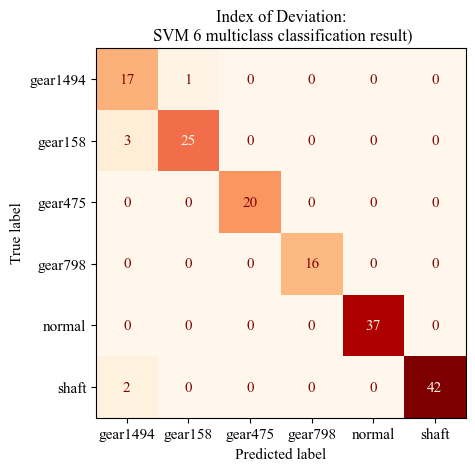

     category         0
0       shaft     shaft
1     gear798   gear798
2     gear158   gear158
3      normal    normal
4     gear158   gear158
..        ...       ...
158  gear1494   gear158
159  gear1494  gear1494
160    normal    normal
161     shaft     shaft
162   gear475   gear475

[163 rows x 2 columns]
['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
n_classes: 6
(163, 6)
label_binarizer.transform([0]): [[0 0 0 0 0 0]]
label_binarizer.classes_ ['gear1494' 'gear158' 'gear475' 'gear798' 'normal' 'shaft']
class_of_interest= 0
class_of_interest= 1
class_of_interest= 2
class_of_interest= 3
class_of_interest= 4
class_of_interest= 5


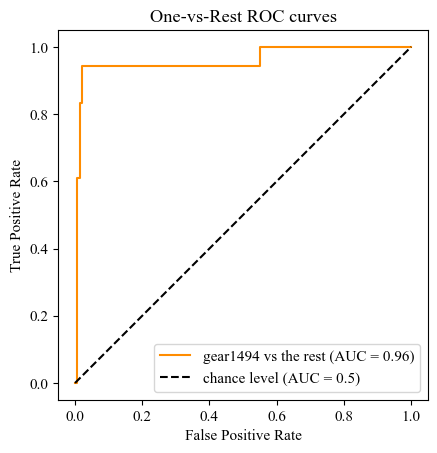

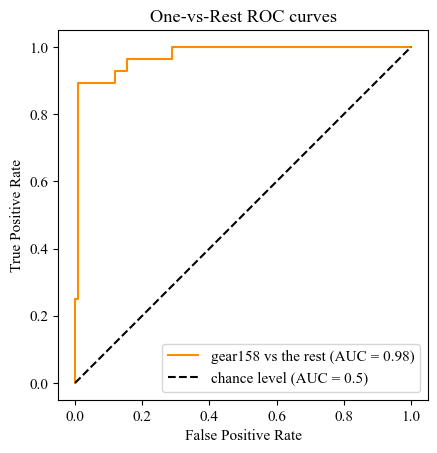

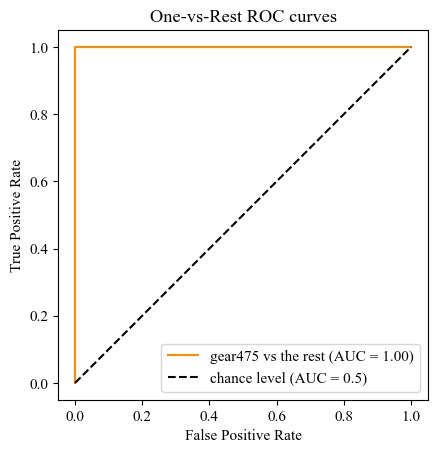

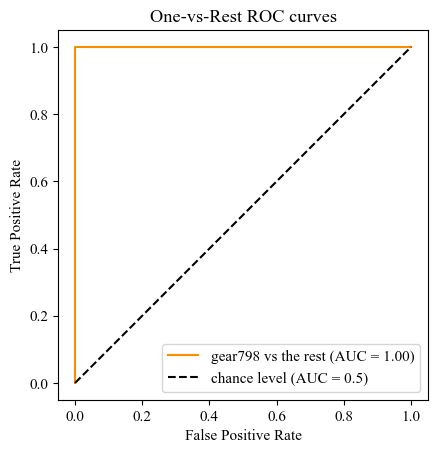

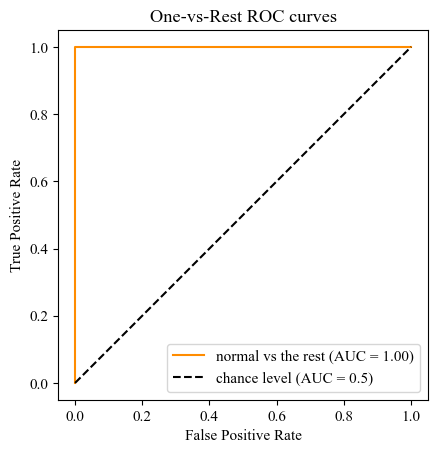

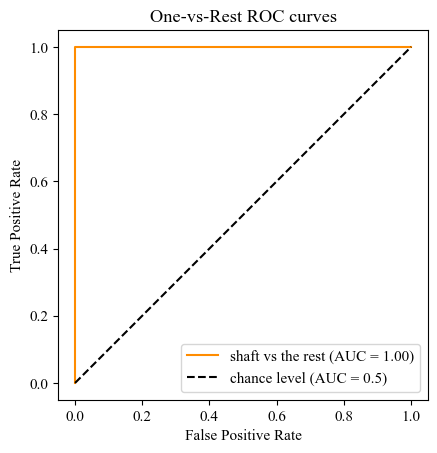

In [4]:
########## SVM+IoD 6 multiclass classification ##########
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

df_sgfilter_svm = pd.read_csv( os.path.join('dataset_ids_features_all', 'dataset_all_IoD_2025-01-06.csv'), header=0)

X = df_sgfilter_svm.iloc[:, 0:25]
# y = df_sgfilter_svm.iloc[:, 25:26]
y = df_sgfilter_svm['category']
y_unit = list[np.unique(y)]
print('y_unit:', y_unit)
class_names = df_sgfilter_svm['category']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, y_train)

poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)

poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

plt.rcParams.update({'font.size':11})
display_labels = ['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
# display_labels = class_names
title_size = 12
colorbar = False
cmap = "OrRd"
values_format = ".0f"

cm = confusion_matrix(y_test, poly_pred, labels=poly.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=display_labels).plot(
                           include_values=True, 
                           cmap=cmap, 
                           colorbar=colorbar, 
                           values_format=values_format)
                       
# plt.axis.set_ticklabels(["Normal", "Gear 158 ", "Gear 475", "Gear 798", 'Gear 1494',  'Shaft' ]    )
plt.title("Index of Deviation:\n SVM 6 multiclass classification result)", size= title_size)

if not os.path.exists( os.path.join('figure') ):
    os.mkdir( os.path.join('figure') )
    plt.savefig(  os.path.join('figure', 'Confusion_matrics_SGMD_IoD_6_classification_SVM.png') ,bbox_inches='tight')
    plt.show()
else:
    plt.savefig(  os.path.join('figure', 'Confusion_matrics_SGMD_IoD_6_classification_SVM.png') ,bbox_inches='tight')
    plt.show()

y_test.reset_index(drop=True, inplace=True)
poly_pred_df = pd.DataFrame(poly_pred)
poly_pred_df.reset_index(drop=True, inplace=True)

testing_dataset_2 = pd.concat( [y_test, poly_pred_df], axis=1 )
print( testing_dataset_2)

if not os.path.exists( os.path.join( 'excel_result') ):
    os.mkdir( os.path.join( 'excel_result') )
    testing_dataset_2.to_csv( os.path.join( 'excel_result', 'SGMD_IoD_testing_dataset_'+now_YMD+'.csv') )
else:
    testing_dataset_2.to_csv( os.path.join( 'excel_result', 'SGMD_IoD_testing_dataset_'+now_YMD+'.csv') )


# feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# feature_importances.plot.bar();

# y_test.reset_index(drop=True, inplace=True)
# y_pred_df = pd.DataFrame(y_pred)
# y_pred_df.reset_index(drop=True, inplace=True)

# testing_dataset_2 = pd.concat( [y_test, y_pred_df], axis=1 )
# print( testing_dataset_2)
# testing_dataset_2.to_csv( os.path.join( 'excel_result', 'SGMD_RandomForest_IoD_testing_dataset_'+now_YMD+'.csv' ) )



from sklearn.metrics import roc_curve, auc  ###計算roc和auc
estimator = poly

class_labels = df_sgfilter_svm['category']
class_labels = pd.unique(class_labels).tolist() #pd.unique:重複的不取 

print( class_labels)
if len(class_labels)==2: #2元分類
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)  #SVM不能用estimator.predict_proba計算機率
            # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_test, y_score) ###計算真正率和假正率
    roc_auc = auc(fpr,tpr) ###計算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率爲橫座標，真正率爲縱座標做曲線
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
else :#6元分類
    n_classes = len(class_labels)
    print( 'n_classes:', n_classes)
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)
    
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import RocCurveDisplay
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    print(y_onehot_test.shape)
    print( 'label_binarizer.transform([0]):' , label_binarizer.transform([0]))
    print( 'label_binarizer.classes_', label_binarizer.classes_ )
    for i in range(n_classes):
        class_of_interest = i
        print( 'class_of_interest=', class_of_interest )
        category_title = label_binarizer.classes_[i]
        # class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_score[:, i],
            name = label_binarizer.classes_[i] + " vs the rest",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("One-vs-Rest ROC curves")
        plt.margins(x=0)
        plt.margins(y=0)
        
        if not os.path.exists( os.path.join('figure')  ):
            os.mkdir( os.path.join('figure'))
            plt.savefig( os.path.join('figure', 'SVM_IoD_6_classification_'+category_title+'.png') ,bbox_inches='tight')
            plt.legend()
        else:
            plt.savefig( os.path.join('figure', 'SVM_IoD_6_classification_'+category_title+'.png') ,bbox_inches='tight')
            plt.legend()
    plt.show()

In [5]:
print(df.columns)

Index(['iod_0', 'iod_1', 'iod_2', 'iod_3', 'iod_4', 'iod_5', 'iod_6', 'iod_7',
       'iod_8', 'iod_9', 'iod_10', 'iod_11', 'iod_12', 'iod_13', 'iod_14',
       'iod_15', 'iod_16', 'iod_17', 'iod_18', 'iod_19', 'iod_20', 'iod_21',
       'iod_22', 'iod_23', 'iod_24', 'category', 'case_ID'],
      dtype='object')


y_unit: list[array(['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft'],
      dtype=object)]
Accuracy: 0.9264
F1 (Index of Deviation):  92.49


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Best hyperparameters: {'max_depth': 17, 'n_estimators': 143}


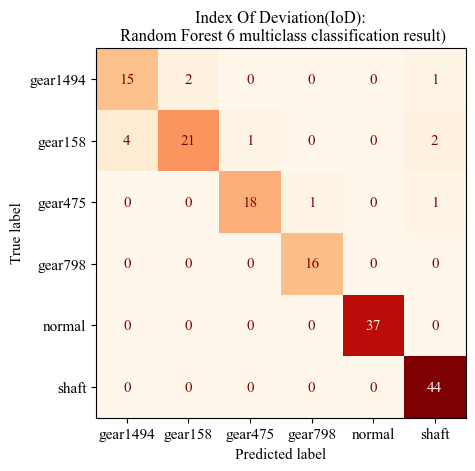

     category         0
0       shaft     shaft
1     gear798   gear798
2     gear158   gear158
3      normal    normal
4     gear158  gear1494
..        ...       ...
158  gear1494  gear1494
159  gear1494  gear1494
160    normal    normal
161     shaft     shaft
162   gear475   gear475

[163 rows x 2 columns]
['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
n_classes: 6


AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

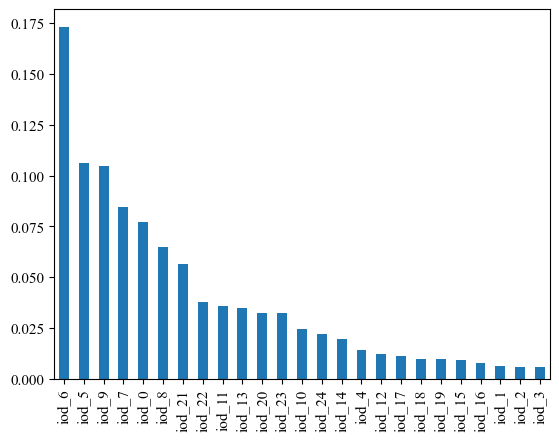

In [6]:
########## Random Forest : SGMD index Of Deviation(IoD) 6 Multiclass ##########
# https://www.datacamp.com/tutorial/random-forests-classifier-python
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz as gv
from sklearn.neighbors import KNeighborsClassifier

df_sgfilter_svm = pd.read_csv( os.path.join('dataset_ids_features_all', 'dataset_all_IoD_2025-01-06.csv'), header=0)

X = df_sgfilter_svm.iloc[:, 0:25]
y = df_sgfilter_svm['category']
y_unit = list[np.unique(y)]
print('y_unit:', y_unit)
class_names = df_sgfilter_svm['category']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
RF_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", round(accuracy,4))
print('F1 (Index of Deviation): ', "%.2f" % (RF_f1_score*100))

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
    

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

y_pred = best_rf.predict(X_test)

display_labels = ['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
colorbar = False
cmap = "OrRd"
values_format = ".0f"
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot()
# cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot(
                            include_values=True, 
                            cmap=cmap, 
                            colorbar=colorbar, 
                            values_format=values_format)

# knn = KNeighborsClassifier(n_neighbors=3)
# knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# print("Accuracy:", round(accuracy,4))
# print("Precision:", round(precision,4) )
# print("Recall:", round(recall,4))
# Plot a simple bar chart
# plt.rcParams.update({'font.size':11})


# plt.axis.set_ticklabels(["Normal", "Gear 158 ", "Gear 475", "Gear 798", 'Gear 1494',  'Shaft' ]    )
title_size = 12
plt.title("Index Of Deviation(IoD):\n Random Forest 6 multiclass classification result)", size= title_size)
plt.savefig(  os.path.join('figure', 'Confusion_matrics_SGMD_IoD_6_classification_RandomForest.png') ,bbox_inches='tight')
plt.show()



feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar();

y_test.reset_index(drop=True, inplace=True)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.reset_index(drop=True, inplace=True)

testing_dataset_2 = pd.concat( [y_test, y_pred_df], axis=1 )
print( testing_dataset_2)
testing_dataset_2.to_csv( os.path.join( 'excel_result', 'SGMD_RandomForest_IoD_testing_dataset_'+now_YMD+'.csv' ) )




from sklearn.metrics import roc_curve, auc  ###計算roc和auc
# estimator = best_rf
estimator = RandomForestClassifier(criterion = 'gini',random_state=42)

class_labels = df_sgfilter_svm['category']
class_labels = pd.unique(class_labels).tolist() #pd.unique:重複的不取 

print( class_labels)
if len(class_labels)==2: #2元分類
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)  #SVM不能用estimator.predict_proba計算機率
            # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_test, y_score) ###計算真正率和假正率
    roc_auc = auc(fpr,tpr) ###計算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率爲橫座標，真正率爲縱座標做曲線
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
else :#6元分類
    n_classes = len(class_labels)
    print( 'n_classes:', n_classes)
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)
    
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import RocCurveDisplay
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    print(y_onehot_test.shape)
    print( 'label_binarizer.transform([0]):' , label_binarizer.transform([0]))
    print( 'label_binarizer.classes_', label_binarizer.classes_ )
    for i in range(n_classes):
        class_of_interest = i
        print( 'class_of_interest=', class_of_interest )
        category_title = label_binarizer.classes_[i]
        # class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_score[:, i],
            name = label_binarizer.classes_[i] + " vs the rest",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("One-vs-Rest ROC curves")
        plt.margins(x=0)
        plt.margins(y=0)
        plt.savefig( os.path.join('figure', 'RF_IoD_6_classification_'+category_title+'.png') ,bbox_inches='tight')
        plt.legend()
    plt.show()

In [ ]:
########## Linear Discrimination Analysis (LDA)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
df = pd.read_csv( os.path.join('dataset_ids_features_all', 'dataset_all_IoD_2025-01-06.csv'), header=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)
lda_model = LDA(n_components = 2)
X_train_lda = lda_model.fit_transform(X_train, y_train)
X_test_lda = lda_model.transform(X_test)

# Predictions and accuracy on the 
y_pred = lda_model.predict(X_test)
print(accuracy_score(y_test, y_pred))


y_pred_accuracy = accuracy_score(y_test, y_pred)
y_pred_f1 = f1_score(y_test, y_pred, average='weighted')
print('Accuracy (LDA): ', "%.2f" % (y_pred_accuracy*100))
print('F1 (LDA): ', "%.2f" % (y_pred_f1*100))

plt.rcParams.update({'font.size':11})
display_labels = ['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
# display_labels = class_names
title_size = 12
colorbar = False
cmap = "OrRd"
values_format = ".0f"

cm = confusion_matrix(y_test, y_pred, labels=lda_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=display_labels).plot(
                           include_values=True, 
                           cmap=cmap, 
                           colorbar=colorbar, 
                           values_format=values_format)
                       
# plt.axis.set_ticklabels(["Normal", "Gear 158 ", "Gear 475", "Gear 798", 'Gear 1494',  'Shaft' ]    )
plt.title("Index of Deviation:\n LDA classification result for 6 multiclass", size= title_size)
plt.savefig(  os.path.join('figure', 'Confusion_matrics_SGMD_IoD_6_classification_LDA.png') ,bbox_inches='tight')
plt.show()

y_test.reset_index(drop=True, inplace=True)
lda_df = pd.DataFrame(y_pred)
lda_df.reset_index(drop=True, inplace=True)

testing_dataset_2 = pd.concat( [y_test, lda_df], axis=1 )
print( testing_dataset_2)
testing_dataset_2.to_csv( os.path.join( 'excel_result', 'LDA_IoD_testing_dataset_'+now_YMD+'.csv') )




from sklearn.metrics import roc_curve, auc  ###計算roc和auc
# estimator = best_rf
estimator = lda_model

class_labels = df_sgfilter_svm['category']
class_labels = pd.unique(class_labels).tolist() #pd.unique:重複的不取 

print( class_labels)
if len(class_labels)==2: #2元分類
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)  #SVM不能用estimator.predict_proba計算機率
            # Compute ROC curve and ROC area for each class
    fpr,tpr,threshold = roc_curve(y_test, y_score) ###計算真正率和假正率
    roc_auc = auc(fpr,tpr) ###計算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率爲橫座標，真正率爲縱座標做曲線
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
else :#6元分類
    n_classes = len(class_labels)
    print( 'n_classes:', n_classes)
    y_score = estimator.fit(X_train, y_train).decision_function(X_test)
    
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.metrics import RocCurveDisplay
    
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    print(y_onehot_test.shape)
    print( 'label_binarizer.transform([0]):' , label_binarizer.transform([0]))
    print( 'label_binarizer.classes_', label_binarizer.classes_ )
    for i in range(n_classes):
        class_of_interest = i
        print( 'class_of_interest=', class_of_interest )
        category_title = label_binarizer.classes_[i]
        # class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, i],
            y_score[:, i],
            name = label_binarizer.classes_[i] + " vs the rest",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("One-vs-Rest ROC curves")
        plt.margins(x=0)
        plt.margins(y=0)
        plt.savefig( os.path.join('figure', 'LDA_IoD_6_classification_'+category_title+'.png') ,bbox_inches='tight')
        plt.legend()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_ids_features_all\\dataset_all_IoD_2024-05-04.csv'

In [23]:
##### Random Forest for Index of Deviation (IoD)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import io, os
# 计算Top k准确率
def top_k_accuracy(y_true, y_prob, k):
    top_k = np.argsort(y_prob, axis=1)[:, -k:]
    hits = np.zeros_like(y_true)
    for i, idx in enumerate(top_k):
        if y_true[i] in idx:
            hits[i] = 1
    return np.mean(hits)


def RandomForest3_Top_k(data,k,random_seed):
    #1.讀取數據特徵

    #取出target
    y = data['y']
    #print(y)
    #取出想要用的feature
    #x = data[['imf2','imf3','imf4','imf5','imf6']]
    #feature_names=['imf2','imf3','imf4','imf5','imf6']
    #print(x)
    # or 取出feature(移除target和不需要的特徵)
    x = data.drop(['case_ID', 'y', 'category'],axis = 1)
    column_names = list(data.columns) #取出data的欄位名稱
    feature_names = column_names[0:25]#取第一個到倒數第2個(最後兩個移除)，移除'target_name','target'
    
#2.劃分數據集
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=random_seed)
#3.模型訓練
    estimator = RandomForestClassifier(criterion = 'gini',random_state=42)
    #加入網格搜索(尋找最佳參數)與交叉驗證
    param_dict = {"n_estimators":[50,100,200,300,400,500],"max_depth":[3,5,7,9]}
    estimator = GridSearchCV(estimator, param_grid=param_dict, cv=4)
    estimator.fit(x_train,y_train)
#4.模型效果
    #取出target_name
    class_names = data['category']
    class_names = pd.unique(class_names).tolist() #pd.unique:重複的不取 
    #print(class_names)
    
    #取出target_labels
    class_labels = data['y']
    class_labels = pd.unique(class_labels).tolist() #pd.unique:重複的不取 
    
#5.找出困難分類樣本
    #預測測試集 機率
    y_pred_prob = estimator.predict_proba(x_test)                      
  
    #method 1: 直接比對真實值和預測值
    y_predict = estimator.predict(x_test)
    #print("y_predict:\n",y_predict)
    #print("直接比對:\n",y_test == y_predict)
    
    accuracy = estimator.score(x_test, y_test)
    #print("accuracy: \n",accuracy)
    #best_params_
    #print("最佳參數:\n",estimator.best_params_)
    
#Top k acc
    y_test = y_test.values #series 轉成array
    top_k_acc = top_k_accuracy(y_test,y_pred_prob,k)
    #print(f"Top {k} accuracy: {top_k_acc:.4f}")

    return estimator,top_k_acc,accuracy
    


    # return y_test,y_predict,estimator,report

In [24]:
data = pd.read_csv( os.path.join('dataset_ids_features_all', 'dataset_all_IoD_2025-01-06.csv' )  )
k = 5
#random_seed = 42
epoch =10
sum_accuracy=0
sum_top_k_acc=0
top_k_error_time = 0
error_time=0
for random_seed in range(epoch):
    [estimator,top_k_acc,accuracy] = RandomForest3_Top_k(data,k,random_seed)
    print(f"第{random_seed}次acc={accuracy}")
    sum_top_k_acc=sum_top_k_acc+top_k_acc
    sum_accuracy=sum_accuracy+accuracy
    if top_k_acc !=1:
        top_k_error_time = top_k_error_time+1
        
    print(f"Top {k} accuracy: {top_k_acc:.4f}")
    if accuracy !=1:
        error_time = error_time+1

        
print("top-k沒有全對的機率=",top_k_error_time/epoch)
print("accuracy沒有全對的機率=",error_time/epoch)
ave_top_k_acc = sum_top_k_acc/epoch
ave_acc = sum_accuracy/epoch
print("ave_top_k_acc =",ave_top_k_acc)
print("ave_acc=",ave_acc)

KeyError: 'y'

y_unit: list[array(['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft'],
      dtype=object)]
Accuracy (Polynomial Kernel):  96.32
F1 (Polynomial Kernel):  96.44


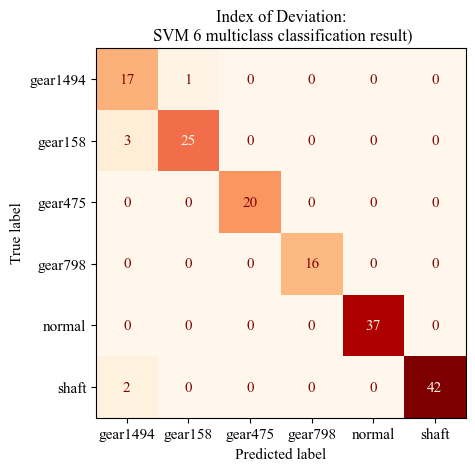

     category         0
0       shaft     shaft
1     gear798   gear798
2     gear158   gear158
3      normal    normal
4     gear158   gear158
..        ...       ...
158  gear1494   gear158
159  gear1494  gear1494
160    normal    normal
161     shaft     shaft
162   gear475   gear475

[163 rows x 2 columns]
['gear1494', 'gear158', 'gear475', 'gear798', 'normal', 'shaft']
n_classes: 6
(163, 6)
label_binarizer.transform([0]): [[0 0 0 0 0 0]]
label_binarizer.classes_ ['gear1494' 'gear158' 'gear475' 'gear798' 'normal' 'shaft']
class_of_interest= 0


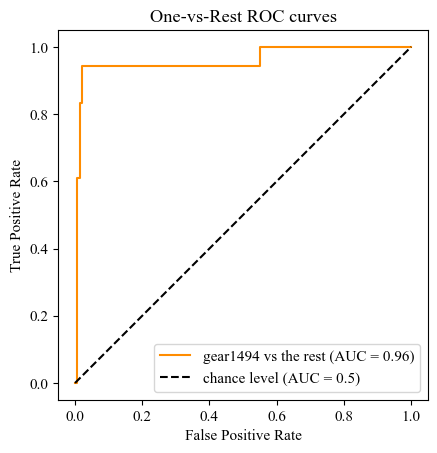

class_of_interest= 1


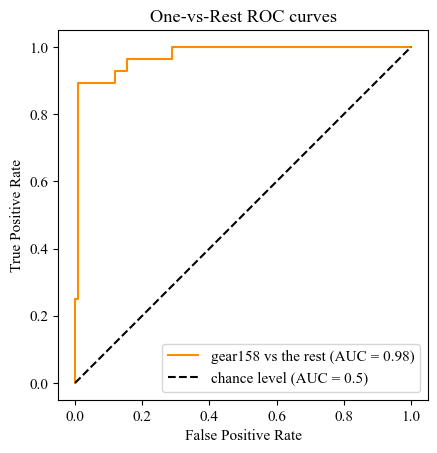

class_of_interest= 2


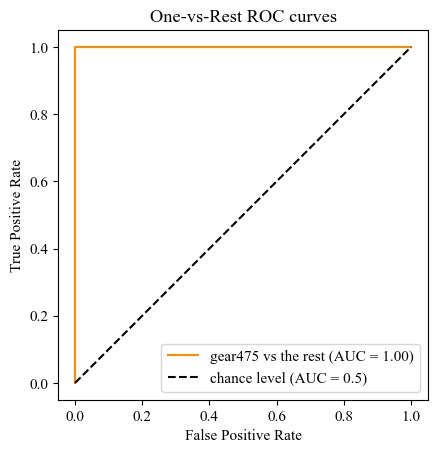

class_of_interest= 3


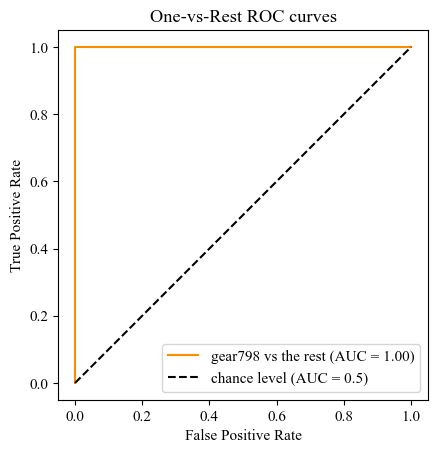

class_of_interest= 4


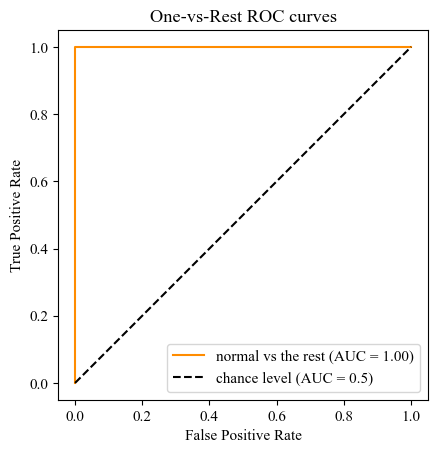

class_of_interest= 5


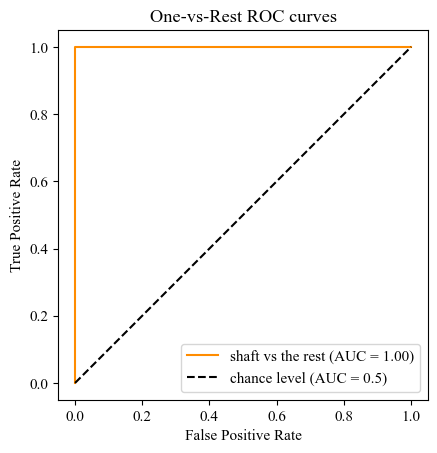

In [2]:
# import util_tools as utools

# data_file_path = os.path.join( 'dataset_ids_features_all', 'dataset_all_IoD_2024-04-08.csv')
# num_cols = 25

# utools.SVM_pipeline( data_file_path, num_cols )

# utools.RandomForest_pipeline( data_file_path, num_cols )

# utools.LDA_pipeline( data_file_path, num_cols )


